In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random


from framework import BaseCouplingLayer
from framework import BaseChunker
from framework import NormalizingFlow

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Training samples shape: torch.Size([5000, 2])


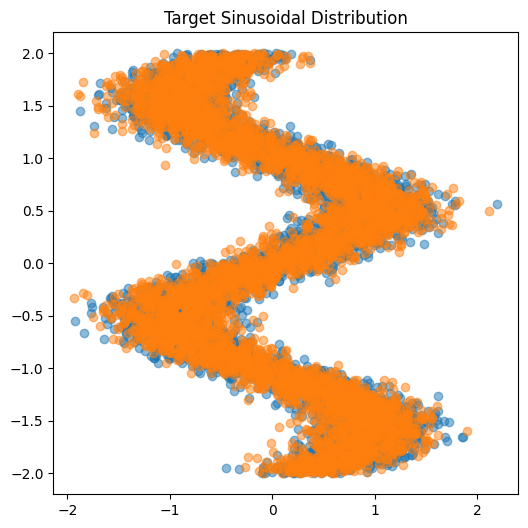

In [2]:
# Define the target distribution as a 2D sinusoidal distribution
def target_distribution(num_samples):
    x = torch.linspace(-2, 2, num_samples)
    y = torch.sin(3 * x) + 0.3 * torch.randn_like(x)  # Adding some noise
    samples = torch.stack([y, x], dim=1)
    return samples


# Generate samples from the target distribution
num_samples = 10000
perm = torch.randperm(num_samples)
target_samples = target_distribution(num_samples)
training_samples = target_samples[perm[:num_samples//2]]
val_samples = target_samples[perm[num_samples//2:]]

print(f"Training samples shape: {training_samples.shape}")

# Plotting
plt.figure(figsize=(6, 6))

# Plot target distribution
plt.scatter(training_samples[:, 0], training_samples[:, 1], alpha=0.5, label='train samples')
plt.scatter(val_samples[:, 0], val_samples[:, 1], alpha=0.5, label='validation samples')
plt.title('Target Sinusoidal Distribution')

plt.show()

In [3]:
class AffineCouplingLayer(BaseCouplingLayer):
    def __init__(self, coupling_function, chunker, should_mask = True):
        super(AffineCouplingLayer, self).__init__()
        self.coupling_function = coupling_function
        self.chunker = chunker
        self.should_mask = should_mask

    def forward(self, x):
        x1, x2 = self.chunker(x)

        scale, shift = self.coupling_function(x1).chunk(2, dim=1)
        y1 = x1
        y2 = x2*torch.exp(scale) + shift
        
        if self.should_mask:
            _, masked_scale = self.chunker(scale)
        else :
            masked_scale = scale
        return self.chunker.invert(y1, y2), masked_scale.view(x.size(0), -1).sum(dim=1)
    
    def inverse(self, y):
        y1, y2 = self.chunker(y)
        scale, shift = self.coupling_function(y1).chunk(2, dim=1)
        x1 = y1
        x2 = (y2 - shift)*torch.exp(-scale)
        return self.chunker.invert(x1, x2)
    
    def log_det_jacobian(self, x):
        x1, x2 = self.chunker(x)
        scale, _ = self.coupling_function(x1).chunk(2, dim=1)
        if self.should_mask:
            _, masked_scale = self.chunker(scale)
        else :
            masked_scale = scale
        return masked_scale.view(x.size(0), -1).sum(dim=1)
    

Training on cpu
Number of parameters: 1352
Epoch [0/2500], Loss: 3.1836049556732178, Val Loss: 3.078260660171509
Epoch [100/2500], Loss: 2.473578453063965, Val Loss: 2.513014078140259
Epoch [200/2500], Loss: 2.2773046493530273, Val Loss: 2.2739739418029785
Epoch [300/2500], Loss: 1.9784739017486572, Val Loss: 2.031574010848999
Epoch [400/2500], Loss: 1.818824291229248, Val Loss: 1.9259400367736816
Epoch [500/2500], Loss: 1.85760498046875, Val Loss: 1.8665752410888672
Epoch [600/2500], Loss: 1.8492872714996338, Val Loss: 1.8532298803329468
Epoch [700/2500], Loss: 1.7136096954345703, Val Loss: 1.8267369270324707
Epoch [800/2500], Loss: 1.7955665588378906, Val Loss: 1.814873456954956
Epoch [900/2500], Loss: 1.6720350980758667, Val Loss: 1.8075755834579468
Epoch [1000/2500], Loss: 1.8305481672286987, Val Loss: 1.8005380630493164
Epoch [1100/2500], Loss: 1.697113275527954, Val Loss: 1.7768887281417847
Epoch [1200/2500], Loss: 1.7522101402282715, Val Loss: 1.7790511846542358
Epoch [1300/2500

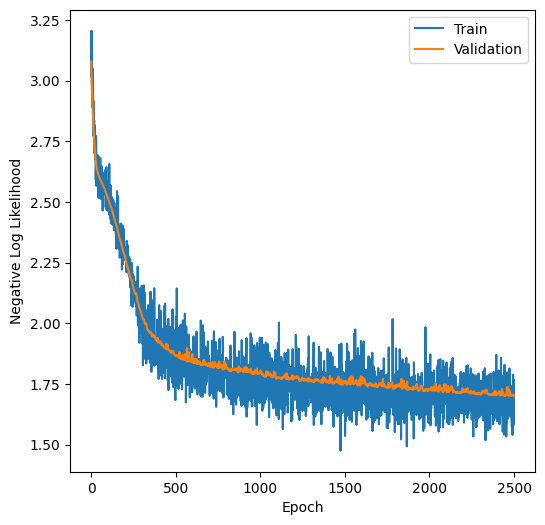

In [4]:
from framework import HalfChunker, NormalizingFlow

# Model Parameters
latent_dim = 2
hidden_dim = 16
latent_distribution = torch.distributions.Normal(0, 1)

# Define the coupling function (a simple rectified MLP)
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.fc3(self.relu(self.fc2(self.relu(self.fc1(x)))))

# Create a list of coupling layers
layers = [
    AffineCouplingLayer(SimpleMLP(1, hidden_dim, latent_dim), HalfChunker(permute=True), should_mask=False),
    AffineCouplingLayer(SimpleMLP(1, hidden_dim, latent_dim), HalfChunker(permute=False), should_mask=False),
    AffineCouplingLayer(SimpleMLP(1, hidden_dim, latent_dim), HalfChunker(permute=True), should_mask=False),
    AffineCouplingLayer(SimpleMLP(1, hidden_dim, latent_dim), HalfChunker(permute=False), should_mask=False),
]

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")

# Define the model
flow = NormalizingFlow(layers, latent_dim, latent_distribution, device=device)

# Print the number of parameters in the model
num_params = sum(p.numel() for p in flow.parameters())
print(f"Number of parameters: {num_params}")

# Training Parameters
batch_size = 128
num_epochs = 2500
learning_rate = 1e-3

# Define the optimizer
optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

# Training Loop
for epoch in range(num_epochs):
    # take a random batch
    perm = torch.randperm(training_samples.size(0))
    batch = training_samples[perm[:batch_size]].to(device)

    # Forward pass
    log_prob = flow.log_prob(batch)
    loss = -torch.mean(log_prob)  # Maximum likelihood estimation)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation

    if epoch % 1 == 0:
        with torch.no_grad():
            val_batch = val_samples.to(device)
            val_log_prob = flow.log_prob(val_batch)
            val_loss = -torch.mean(val_log_prob)

            if epoch % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}, Val Loss: {val_loss.item()}")
            train_losses.append(loss.item())
            val_losses.append(val_loss.item())
    else:
        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}")
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

# Plot the training and validation losses
plt.figure(figsize=(6, 6))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.show()

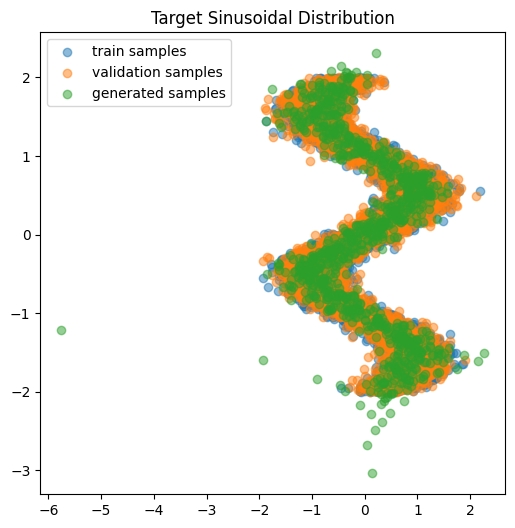

In [5]:
generated_samples = flow.sample(1000).detach().cpu()

# Plotting
plt.figure(figsize=(6, 6))

# Plot target distribution
plt.scatter(training_samples[:, 0], training_samples[:, 1], alpha=0.5, label='train samples')
plt.scatter(val_samples[:, 0], val_samples[:, 1], alpha=0.5, label='validation samples')

# Plot generated samples
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, label='generated samples')
plt.title('Target Sinusoidal Distribution')

plt.legend()

plt.show()